In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt

In [3]:
!pwd

/Users/utkarsh/NYU/Monte Carlo Methods/Homeworks/homework6/src


In [6]:
from AuxilaryFxns import *

In [21]:
class OverdampedStochasticNewtonSchemeBase:
    def __init__(self, M, h, method, scaleupConst = 1000000):
        self.M = M
        self.h = h
        self.scalingFactor = scaleupConst
        self.method = method
        self.N = int(scaleupConst/h)

        #Let's compute the x coordinate for visualization
        self.f = np.zeros((self.N, self.M))

        out = np.split(np.arange(self.N), 20)
        index = []
        for o in out:
            index.append(o[-1] + 1)
        self.IAT_sliceIndexOnePast = np.array(index)
        self.IATs = np.zeros((M,20))

    # x would be M, and y would be M,
    def Compute_f_field(self, x, y):
        return np.zeros((self.M,)) #Returning shape is M,

    def ComputeIATs(self):
        for listIndex, sliceIndex in enumerate(self.IAT_sliceIndexOnePast):
            taus = np.zeros((self.M,))
            for m in range(self.M):
                out = integrated_time(self.f[0:sliceIndex, m], c=5, tol=50, quiet=True)
                if np.isnan(out):
                    taus[m] = 0
                else:
                    taus[m] = out
            self.IATs[:, listIndex] = taus
        return

    def GenerateHistograms(self, exerciseName, index):
        titleString = exerciseName + '_' + self.method + " |h:" + str(self.h) + " |Samples:" + str(
            self.IAT_sliceIndexOnePast[index]) + " |beta:" + str(self.beta) + " |L:" + str(self.L)
        saveFigName = exerciseName + '_' + self.method + "_h_" + str(self.h) + "_Samples_" + str(
            self.IAT_sliceIndexOnePast[index]) + "_beta_" + str(self.beta) + "_L_" + str(self.L)
        saveFigName = saveFigName.replace('.', 'd')

        fig, ax = plt.subplots()  # fig : figure object, ax : Axes object
        #Make sure here that only one trajectory is remaining in self.cosines #TODO
        ax.hist(self.cosines[:self.IAT_sliceIndexOnePast[index]])
        ax.set_xlabel('Cosine of angle of Magnetization Vector')
        ax.set_title(titleString)
        fig.savefig('Histogram_' + saveFigName)
        plt.close(fig)
        return

    def GenerateIATGraphs(self, exerciseName, index):
        titleString = exerciseName + '_' + self.method + " |h:" + str(self.h) + " |Samples:" + str(self.IAT_sliceIndexOnePast[index]) + " |beta:" + str(self.beta) + " |L:" + str(self.L)
        saveFigName = exerciseName + '_' + self.method + "_h_" + str(self.h) + "_Samples_" + str(self.IAT_sliceIndexOnePast[index]) + "_beta_" + str(self.beta) + "_L_" + str(self.L)
        saveFigName = saveFigName.replace('.', 'd')

        x = np.arange(self.M)
        fig, ax = plt.subplots()  # fig : figure object, ax : Axes object

        ax.plot(x, self.IATs[:, index], '-o');
        ax.set_xlabel('Trajectories Index')
        ax.set_ylabel('Integrated Autocorrelation Time')

        ax.set_title(titleString)
        ax.set_xticks(x)
        fig.savefig(saveFigName)
        plt.close(fig)
        return

#Class for question 71
#   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -  #
#                                                                                                      #
#                                                                                                      #
#   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -   -  #
class OverdampedStochasticNewtonScheme(OverdampedStochasticNewtonSchemeBase):
    def __init__(self, M, h, method, x, y, scaleupConst=1000000):
        super().__init__(M, h, method, scaleupConst)
        self.xs = np.zeros((self.N, self.M, 2))
        self.xs[0,:,0] = x
        self.xs[0,:,1] = y


    def GetNextTimestampXs(self, k):
        #old_xs[:,0] #Shape will be (M, )
        old_xs = self.xs[k-1,:,:] #Shape will be (Mx2)

        grad = GetOutputOf_grad_of_log_pi(old_xs[:,0], old_xs[:,1]) # M x 2
        S_matrix = GetSMatrix(old_xs[:,0], old_xs[:,1], self.method) #Shape is M x 2 x 2

        SDotGrad = GetReqProduct(self.M, S_matrix, grad) #It would be M x 2

        root_S = GetSquareRootOfS(S_matrix, self.method) # shape is M x 2 x 2
        zetas = np.random.normal(0, 1, (self.M,2))  # M x 2 #This is standard normal

        root_SDotzeta = GetReqProduct(self.M, root_S, zetas) #It would be M x 2

        new_xs = old_xs + self.h * SDotGrad + np.sqrt(2 * self.h) * root_SDotzeta
        return new_xs #Shape should be M x 2


    def UpdateForMetropolization(self,boolArray, next_xs, old_xs):
        #old_xs are M x 2
        #new_xs are M x 2
        bools = boolArray.reshape(boolArray.shape[0], 1) # It will be M x 1
        z = np.where(bools, next_xs, old_xs)
        return z

    def ElongateChain(self):
        self.f[0,:] = self.xs[0,:,0] #Evaluating the first coordinate of the matrix
        for i in range(1, self.N):
            next_xs = self.GetNextTimestampXs(i)  # M x 2
            ratio = GetRatiosOf_Fxn_pi(next_xs[:,0],next_xs[:,1], self.xs[i-1,:,0], self.xs[i-1,:,1])
            p_acc = np.minimum(np.ones((self.M,)), ratio)
            randNum = np.random.uniform(low=0, high=1.0, size=(self.M,))
            boolArray = randNum < p_acc
            updated_xs = self.UpdateForMetropolization(boolArray, next_xs, self.xs[i-1,:,:])
            self.xs[i,:,:] = updated_xs
            self.f[i,:] = self.xs[i,:,0]
        return

class EnsembleMCMC(OverdampedStochasticNewtonSchemeBase):
    def __init__(self, M, h, alpha, method, mean = 0, std = 1, scaleupConst=1000000):
        super().__init__(M, h, method, scaleupConst)
        self.xs = np.zeros((self.N, self.M, 2))
        self.xs[0,:,:] = np.random.multivariate_normal(mean = np.zeros(2,), cov= np.identity(2), size = M) #This shape should be M x 2
        self.alpha = alpha

    def GetNextTimestampXs(self, z, i_index, k):
        i_index_x = self.xs[k-1, i_index, :] #Shape will be (2,)

        j_index = i_index
        while j_index == i_index :
            j_index = np.random.randint(0,self.M)

        j_index_x = self.xs[k-1, j_index, :] #Shape will be (2,)
        y = j_index_x + z * (i_index_x - j_index_x) #Should be (2,)
        return y #(2, )

    def UpdateForMetropolization(self,boolArray, next_xs, old_xs):
        #old_xs are M x 2
        #new_xs are M x 2
        bools = boolArray.reshape(boolArray.shape[0], 1) # It will be M x 1
        z = np.where(bools, next_xs, old_xs)
        return z

    def ElongateChain(self):
        #F can't be computed same way,ask what to do here
        self.f[0,:] = self.xs[0,:,0] #Evaluating the first coordinate of the matrix

        for iteration_k in range(1, self.N):
            for i_traj in range(0, self.M):
                z = GenerateZ(self.alpha)
                old_x = self.xs[iteration_k - 1, i_traj, :] #Should be (2,)
                y = self.GetNextTimestampXs(z, i_traj, iteration_k) #Should be (2,)
                ratio_pi = GetRatiosOf_Fxn_pi(y[0], y[1], old_x[0], old_x[1])
                zTimesRatio = z * ratio_pi
                randNum = np.random.uniform(low=0, high=1.0)
                p_acc = np.minimum(1, zTimesRatio)
                boolValue = randNum < p_acc
                updated_xs = np.where(boolValue, y, old_x)
                self.xs[iteration_k,i_traj,:] = updated_xs
                self.f[iteration_k,i_traj] = self.xs[iteration_k, i_traj,0]
        return


In [10]:
def Simulation(model):
    model.ElongateChain()
    return model



In [31]:
x = np.random.random(1)
y = np.random.random(1)

model = OverdampedStochasticNewtonScheme(10, 0.005, 'langevin', x, y, scaleupConst=10)#50000)
model = Simulation(model)
avg_x  = np.mean(model.xs[:,:,0], axis = 1)
avg_y = np.mean(model.xs[:,:,1], axis= 1)

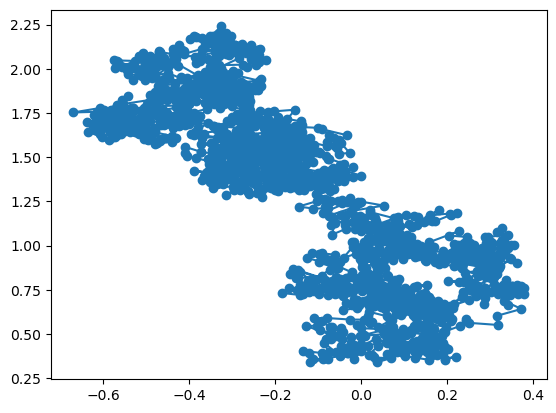

In [32]:
plt.plot(avg_x, avg_y, '-o')

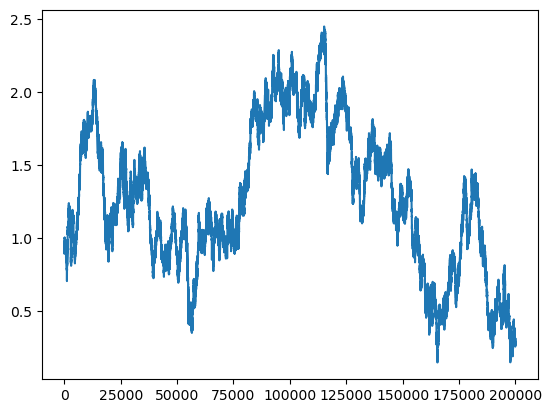

In [19]:
plt.plot(avg_x)

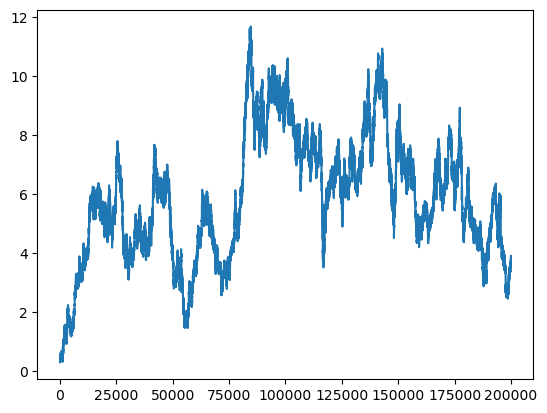

In [20]:
plt.plot(avg_y)

In [24]:
model2 = EnsembleMCMC(10, 0.0005, 2, 'M', scaleupConst=100)
model2 = Simulation(model2)
avg_x2  = np.mean(model2.xs[:,:,0], axis = 1)
avg_y2 = np.mean(model2.xs[:,:,1], axis= 1)
t = 0
#Working correctly, just checked ensemble

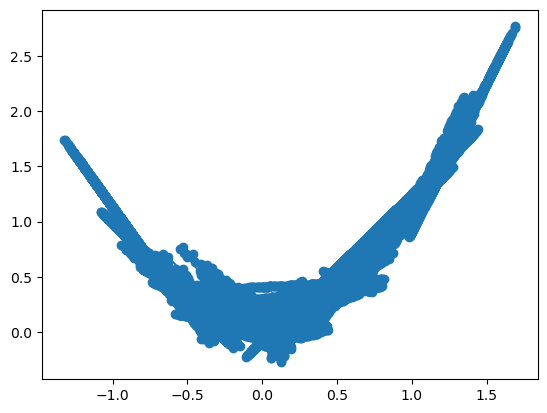

In [25]:
plt.plot(avg_x2, avg_y2, '-o')

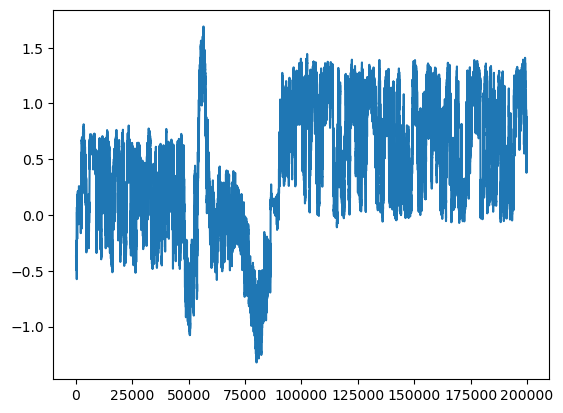

In [26]:
plt.plot(avg_x2)

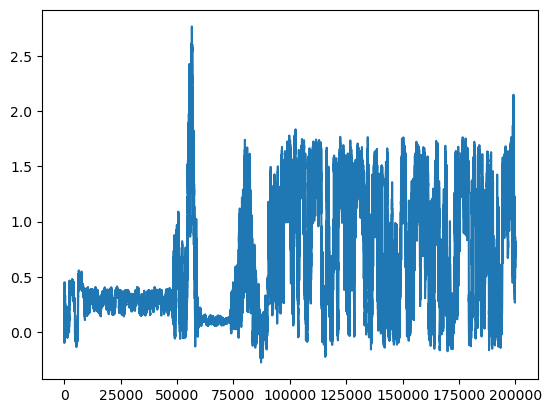

In [27]:
plt.plot(avg_y2)

(array([5283., 2178., 1834., 1643., 1543., 1675., 1696., 1783., 2289.,
        5076.]),
 array([-1.00000000e+00, -8.00000000e-01, -6.00000000e-01, -4.00000001e-01,
        -2.00000001e-01, -1.91575356e-09,  1.99999998e-01,  3.99999997e-01,
         5.99999997e-01,  7.99999996e-01,  9.99999996e-01]),
 <BarContainer object of 10 artists>)

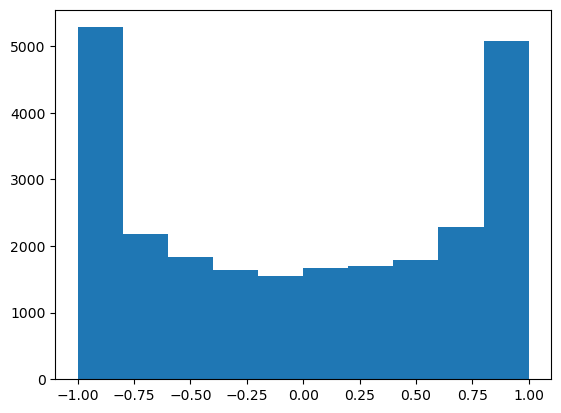

In [45]:
plt.hist(out.cosines)

(array([5247., 2091., 1749., 1661., 1639., 1664., 1722., 1832., 2244.,
        5151.]),
 array([-9.99999994e-01, -7.99999995e-01, -5.99999995e-01, -3.99999996e-01,
        -1.99999997e-01,  2.48931964e-09,  2.00000002e-01,  4.00000001e-01,
         6.00000000e-01,  8.00000000e-01,  9.99999999e-01]),
 <BarContainer object of 10 artists>)

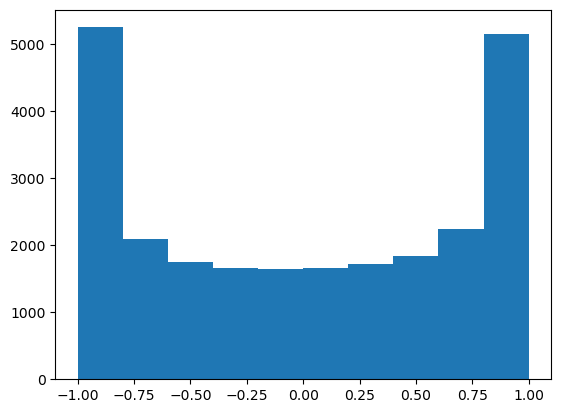

In [46]:
plt.hist(out1.cosines)

In [5]:
def RunSimulationQuestion_64(beta, L, M, h, initialValues, scaleupConst):
    method_name = ['notMH', 'MH']
    #First one is without notMH and second one is with MH
    out = Parallel(n_jobs = 2, verbose = 10)(delayed(GenerateSamplesFromOverdampled)(beta, L, M, h, method, initialValues, scaleupConst) for method in method_name)
    return out

def RunSimulationQuestion_65(beta, L, M, h, initialValues, scaleupConst, n = 100):
    method_name = ['notMH', 'MH']
    #First one is without notMH and second one is with MH
    out = Parallel(n_jobs = 2, verbose = 10)(delayed(GenerateSamplesFromHybrid)(beta, L, M, h, method, initialValues, scaleupConst, n) for method in method_name)
    return out

def RunSimulationQuestion_66(beta, L, M, h, gamma, initialValues, scaleupConst):
    method_name = ['notMH', 'MH']
    #First one is without notMH and second one is with MH
    out = Parallel(n_jobs = 2, verbose = 10)(delayed(GenerateSampleFromUnderdamped)(beta, L, M, h, method, initialValues, scaleupConst, gamma) for method in method_name)
    return out


def RunTestsOnQuestion_64(beta, L, M, initialValues, hs, scaleupConst):
    out = Parallel(n_jobs = 4, verbose = 10)(delayed(RunSimulationQuestion_64)(beta, L, M, h, initialValues, scaleupConst) for h in hs)
    return out

def RunTestsOnQuestion_65(beta, L, M, initialValues, hs, scaleupConst, n = 100):
    out = Parallel(n_jobs = 4, verbose = 10)(delayed(RunSimulationQuestion_65)(beta, L, M, h, initialValues, scaleupConst, n) for h in hs)
    return out

def RunTestsOnQuestion_66(beta, L, M, initialValues, hs, gammas, scaleupConst):
    params = []
    for i in hs:
        for j in gammas:
            params.append((i, j))

    out = Parallel(n_jobs = 4, verbose = 10)(delayed(RunSimulationQuestion_66)(beta, L, M, h, gamma, initialValues, scaleupConst) for h, gamma in params)
    return out

In [6]:
#Test All the Code
beta = 0.2
L = 3
M = 7
n = 100
scaleupConst = 1e4  #These are number of samples generated for h = 1

initialValues = np.random.random_sample((L, 1))
ieee_remainder = np.vectorize(math.remainder)
initialValues = ieee_remainder(initialValues, math.tau)

hs = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6,1e-7]
hs = [1e-1, 1e-2]
gammas = [1e-1, 1, 1e1,]
scaleupConst = 1e1

In [7]:
ex64_out =  RunTestsOnQuestion_64(beta, L, M, initialValues, hs, scaleupConst)
ex_65_out = RunTestsOnQuestion_65(beta, L, M, initialValues, hs, scaleupConst, n = 100)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.34283552]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.52448523]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.49402872]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.14916034]
The chain is shorter than 50 times the integrated autocorrelation tim

In [12]:
o1 = np.array(ex64_out)

In [13]:
o1.shape

(2, 2)

In [17]:
print(o1[0,0].IAT_sliceIndexOnePast.shape)
print(o1[0,0].IATs.shape)


(20,)
(7, 20)


In [19]:
import matplotlib.pyplot as plt

findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=12.0. MainThread MainProcess
findfont: score(FontEntry(fname='/Users/Shared/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05 MainThread MainProcess
findfont: score(FontEntry(fname='/Users/Shared/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 1.335 MainThread MainProcess
findfont: score(FontEntry(fname='/Users/Shared/anaconda3/lib/python3.9/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 1.05 MainThread MainProcess
findfont: score(FontEntry(fname='/Users/Shared/anacon

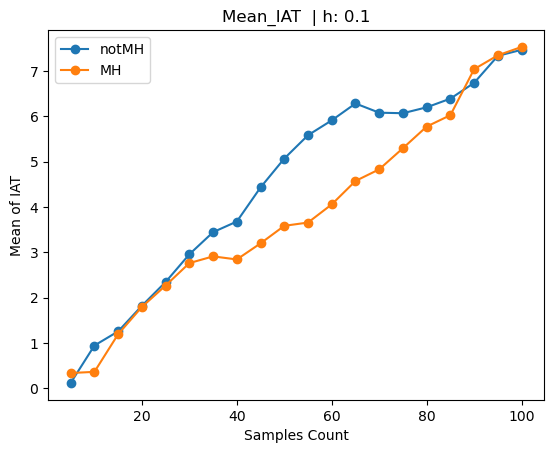

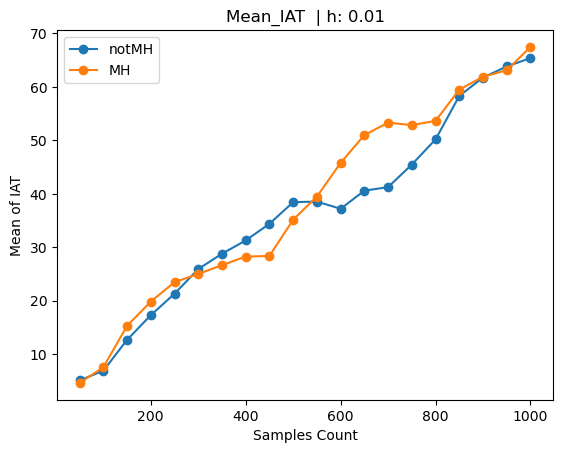

In [23]:
rows, cols = o1.shape
for row in range(rows):

    fig, ax = plt.subplots()  # fig : figure object, ax : Axes object
    ax.set_xlabel('Samples Count')
    ax.set_ylabel('Mean of IAT')
    titleString = 'Mean_IAT ' + " | h: " + str(o1[row][0].h)
    for col in range(cols):  
        N_array = o1[row][col].IAT_sliceIndexOnePast
        mean_IATs = np.mean(o1[row][col].IATs, axis = 0) #Should be of shape N,
        std_IATs = np.std(o1[row][col].IATs, axis = 0) #Should be of shape N,
        labelString = o1[row][col].method
        ax.plot(N_array, mean_IATs, '-o', label = labelString);
    ax.legend()
    ax.set_title(titleString)

In [24]:
def MidRunForGammas(beta, L, M, initalValues, h, gamas,scaleupConst):
    out = Parallel(n_jobs = 1, verbose = 10)(delayed(RunSimulationQuestion_66)(beta, L, M, h, gamma, initalValues, scaleupConst) for gamma in gamas)
    return out

def RunTestsOnQuestion_66(beta, L, M, initialValues, hs, gammas, scaleupConst):
    out = Parallel(n_jobs= 4, verbose= 10)(delayed(MidRunForGammas)(beta, L, M, initialValues, h, gammas, scaleupConst)for h in hs)
    return out


In [25]:
f = RunTestsOnQuestion_66(beta, L, M, initialValues, hs, gammas, scaleupConst)

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.34215028]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.4985288]
The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 0;
tau: [0.47343201]
The chain is shorter than 50 times the integrated autocorrelation time for 1 param

In [27]:
f1 = np.array(f)

In [28]:
f1.shape

(2, 3, 2)